In [1]:
import os
import torch
import numpy as np
import PIL
from PIL import Image
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import copy
import pandas as pd

from tqdm import tqdm
from torch.utils import data

from torchvision.datasets import VisionDataset
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from typing import Optional, Callable
def encode_labels(target):
    k = np.zeros((10))
  
    return torch.from_numpy(k)

In [2]:
import torchvision
from torch.utils.data.dataloader import DataLoader
#download data
# image = torchvision.datasets.VOCDetection(root='./data',year='2011',image_set='train',download = False, target_transform=encode_labels)


In [3]:
class PascalVOC2011(VisionDataset):
    def __init__(self, voc_dataset_dir):        
        #Define dataset
        #In the training set, combine PASCAL VOC 2012 with SBD
        self.dataset = [torchvision.datasets.VOCDetection(root=voc_dataset_dir,year='2011',image_set='train',download = False, target_transform=encode_labels)]
     
    def __len__(self):
        return 1200
    
    def __getitem__(self, idx):
        if idx < len(self.dataset[0]):
            chosen_dataset = self.dataset[0]
        else:
            chosen_dataset = self.dataset[1]
            idx = idx - len(self.dataset[0])
        imagepil, targetpil = chosen_dataset[idx]
        origin_size = 240
        image = trans_img(imagepil, origin_size)
        
        image_small = trans_img(imagepil, int(origin_size*0.5))
        transform = transforms.Resize(240)
        image_small = transform(image_small)
        return image, image_small

def trans_img(img, size):
    ChosenTransforms = torchvision.transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])

    image = ChosenTransforms(img)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(size,size),mode='bilinear', align_corners=False)
    image = image.squeeze()
    return image


In [4]:
dataset = PascalVOC2011("./data")#./data


data_dir = './data/TrainVal/VOCdevkit/VOC2011/JPEGImages/'
# dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
              

train, val, test = torch.utils.data.random_split(dataset, [int(0.6*len(dataset)),
                                                     int(0.39*len(dataset)),
                                                     int(0.01*len(dataset)),
                                                    ])

batch_size = 16
num_workers = 4

dataloaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers),
}

# dataloaders = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                           shuffle=False, num_workers=2)

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val', 'test']}
# dataset_sizes = len(dataloaders)
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 45, 'val': 30, 'test': 1}


In [5]:
len(dataset)

1200

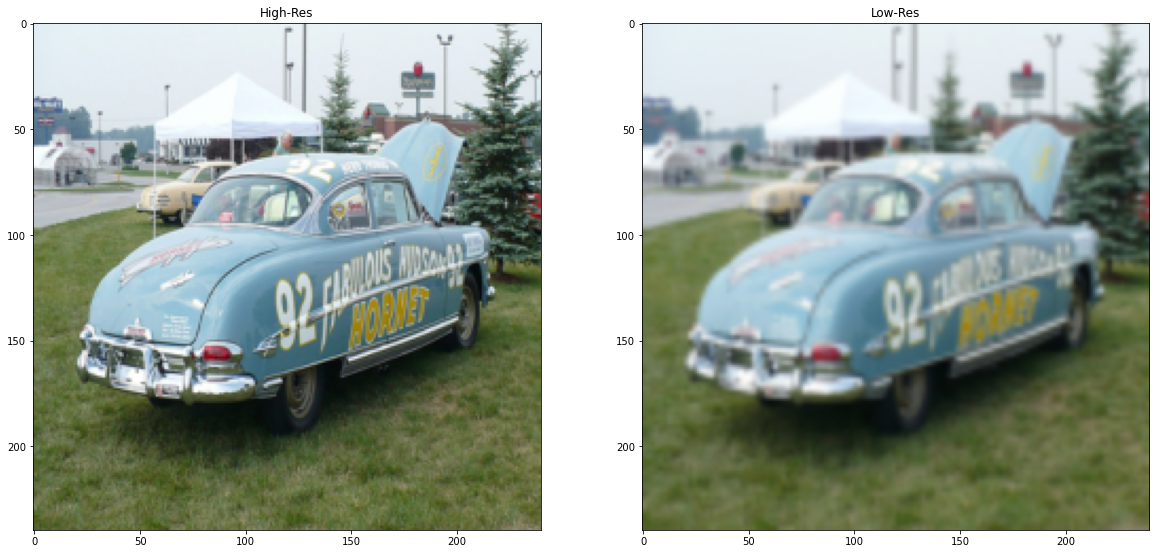

In [6]:
for i in dataloaders['train']:
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0))
    axarr[1].imshow(i[1][0].permute(1, 2, 0))
    axarr[0].set_title("High-Res")
    axarr[1].set_title("Low-Res")
    break

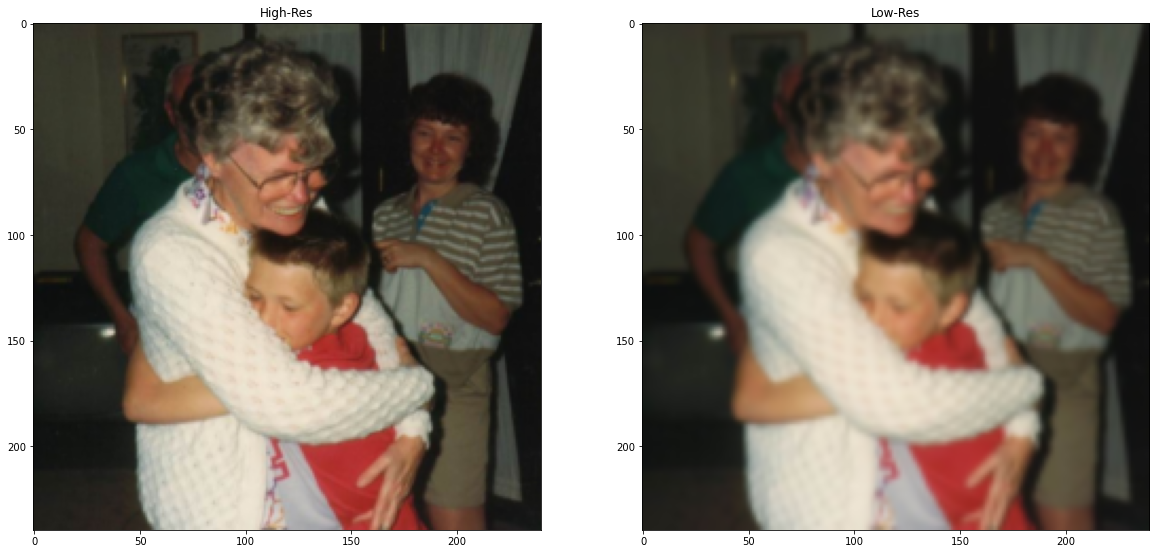

In [7]:
for i in dataloaders['val']:
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0))
    axarr[1].imshow(i[1][0].permute(1, 2, 0))
    axarr[0].set_title("High-Res")
    axarr[1].set_title("Low-Res")
    break

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [10]:
model = SRCNN().to(device)
# summary(srcnn, (3, 240, 240))

In [11]:
# def calc_psnr(img1, img2):
#     return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))

def PSNR(original, compressed):
    mse = torch.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20. * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
#     batch = batch.div(255.0)
    return (batch - mean) / std


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
from collections import namedtuple

import torch
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [13]:
vgg = Vgg16(requires_grad=False).to(device)
vgg

Vgg16(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (sli

In [14]:
def calc_perceptual_loss(img1,img2):
    outputs_vgg = vgg(img1)
    ground_truth_vgg = vgg(img2)
    loss1_2 = criterion(outputs_vgg.relu1_2, ground_truth_vgg.relu1_2)
    loss2_2 = criterion(outputs_vgg.relu2_2, ground_truth_vgg.relu2_2)
    loss3_3 = criterion(outputs_vgg.relu3_3, ground_truth_vgg.relu3_3)
    loss4_3 = criterion(outputs_vgg.relu4_3, ground_truth_vgg.relu4_3)
    loss = loss1_2 + loss2_2 + loss3_3 + loss4_3
    return loss

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
    # Init variables that will save info about the best model
#     best_model_wts = copy.deepcopy(model.state_dict())
#     vgg = models.vgg16(pretrained=True)
    vgg = Vgg16(requires_grad=False).to(device)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 100.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Set model to training mode. 
        model.train()  
        epoch_losses = AverageMeter()
        

        train_running_loss = 0.0
        val_running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for high_res_batch, low_res_batch in dataloaders['train']:
            optimizer.zero_grad()
            # Prepare the inputs for GPU/CPU
            high_res_batch = high_res_batch.to(device).float()
            low_res_batch = low_res_batch.to(device).float()

#             tensor_input = low_res_batch.float()
            outputs_srcnn = model(low_res_batch)
            
            high_res_batch = normalize_batch(high_res_batch)
            low_res_batch = normalize_batch(low_res_batch)
            outputs_srcnn = normalize_batch(outputs_srcnn)
            
            loss = calc_perceptual_loss(outputs_srcnn, high_res_batch)
            
            loss.backward() # Perform a step in the opposite direction of the gradient
            optimizer.step() # Adapt the optimizer

#             Collect statistics
            train_running_loss += loss.item()
            epoch_losses.update(train_running_loss, len(high_res_batch))


            # Adjust the learning rate based on the scheduler
        print('train loss: {:.5f}'.format(epoch_losses.avg))# / dataset_sizes['train']
#         print('train psnr: {:.2f}'.format(epoch_psnr.avg))
        
        model.eval()
        val_epoch_losses = AverageMeter()
        epoch_psnr = AverageMeter()

        for high_res_batch, low_res_batch in dataloaders['val']:
            high_res_batch = high_res_batch.to(device).float()
            low_res_batch = low_res_batch.to(device).float()

            with torch.no_grad():
                preds = model(low_res_batch).clamp(0.0, 1.0)
                
                low_res_batch = normalize_batch(low_res_batch)
                high_res_batch = normalize_batch(high_res_batch)
                preds = normalize_batch(preds)

                loss = calc_perceptual_loss(preds, high_res_batch)
                val_running_loss += loss.item()
                
                val_epoch_losses.update(val_running_loss, len(high_res_batch))
                psnr = PSNR(low_res_batch, high_res_batch) - PSNR(preds, high_res_batch)
                epoch_psnr.update(psnr, len(high_res_batch))

        print('val loss: {:.5f}'.format(val_epoch_losses.avg))# / dataset_sizes['train']
        print('psnr: {:.2f} (reconstructed:{:.5f} low_res:{:.5f})'.format(epoch_psnr.avg, PSNR(preds, high_res_batch), PSNR(low_res_batch, high_res_batch)))

        avg_epoch_psnr = epoch_psnr.avg.cpu().detach().numpy()

        if avg_epoch_psnr < best_psnr:
            best_epoch = epoch
            best_psnr = avg_epoch_psnr
            best_weights = copy.deepcopy(model.state_dict())
            print('--- New best - saving weights ---')
            
        print()
#         print('outputs',outputs)

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val psnr: {best_psnr:4f}')
    print(f'Best epoch: {best_epoch:4f}')

    # load best model weights
    model.load_state_dict(best_weights)
    return model

In [15]:


# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.MSELoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 100

In [16]:
model = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)

Epoch 0/99
----------
train loss: 481.01868
val loss: 214.27072
psnr: 16.22 (reconstructed:45.85223 low_res:64.79597)
--- New best - saving weights ---

Epoch 1/99
----------
train loss: 297.13759
val loss: 164.25146
psnr: 12.09 (reconstructed:50.10025 low_res:64.79597)
--- New best - saving weights ---

Epoch 2/99
----------
train loss: 236.70503
val loss: 141.99604
psnr: 5.52 (reconstructed:57.23166 low_res:64.79597)
--- New best - saving weights ---

Epoch 3/99
----------
train loss: 210.33203
val loss: 130.68693
psnr: 1.39 (reconstructed:62.19822 low_res:64.79597)
--- New best - saving weights ---

Epoch 4/99
----------
train loss: 196.96608
val loss: 125.50215
psnr: 1.07 (reconstructed:62.64188 low_res:64.79597)
--- New best - saving weights ---

Epoch 5/99
----------
train loss: 188.66807
val loss: 121.77104
psnr: 0.15 (reconstructed:63.85955 low_res:64.79597)
--- New best - saving weights ---

Epoch 6/99
----------
train loss: 185.33777
val loss: 119.51190
psnr: 0.39 (reconstruc

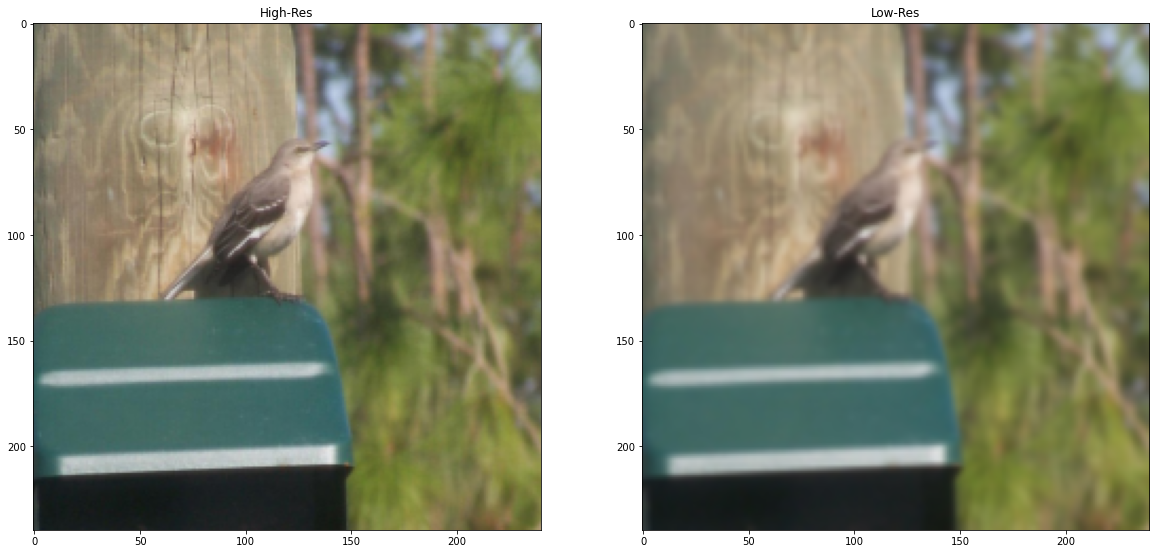

In [17]:
for i in dataloaders['test']:
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0))
    axarr[1].imshow(i[1][0].permute(1, 2, 0))
    axarr[0].set_title("High-Res")
    axarr[1].set_title("Low-Res")
    break

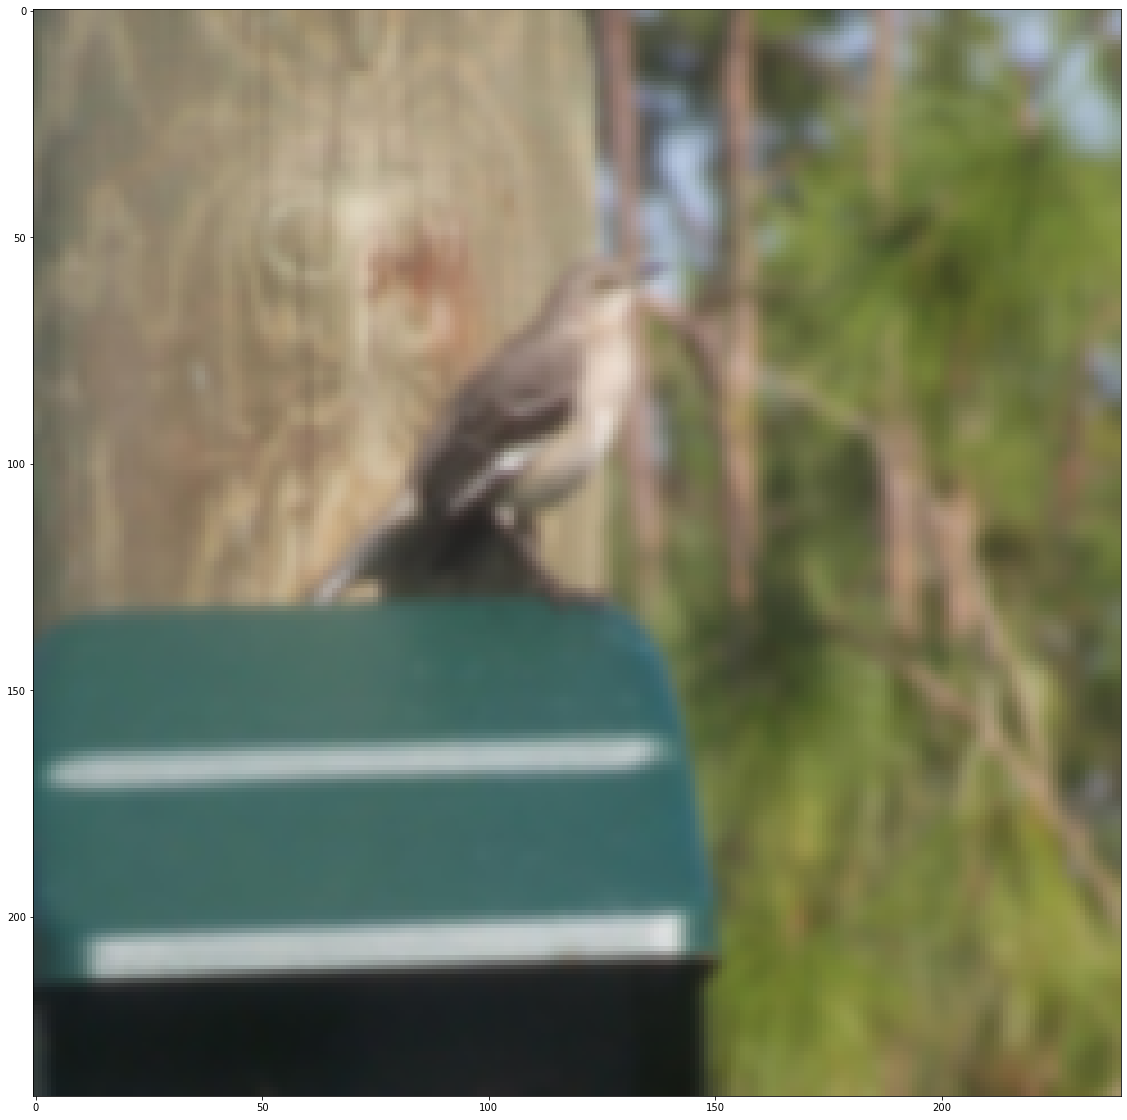

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(i[1][0].permute(1,2,0))

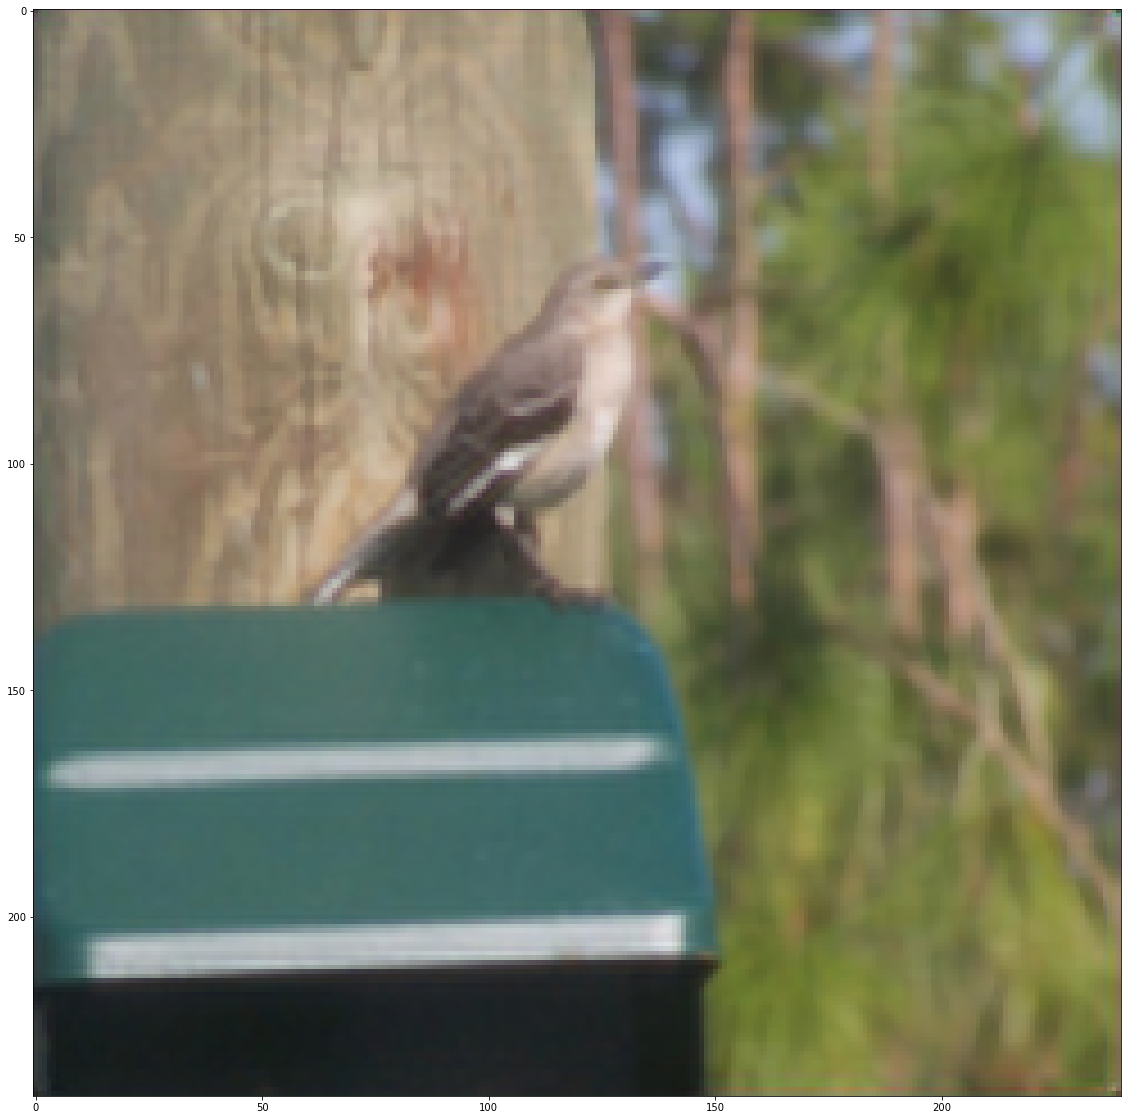

In [25]:
model.eval()
inputs = i[1][0]
inputs = inputs.to(device).float()
out = model(inputs.unsqueeze(0))
plt.figure(figsize=(20,20))
image = out.squeeze(0).permute(1, 2, 0).cpu().detach()
plt.imshow(image)

Text(0.5, 1.0, 'Low-Res')

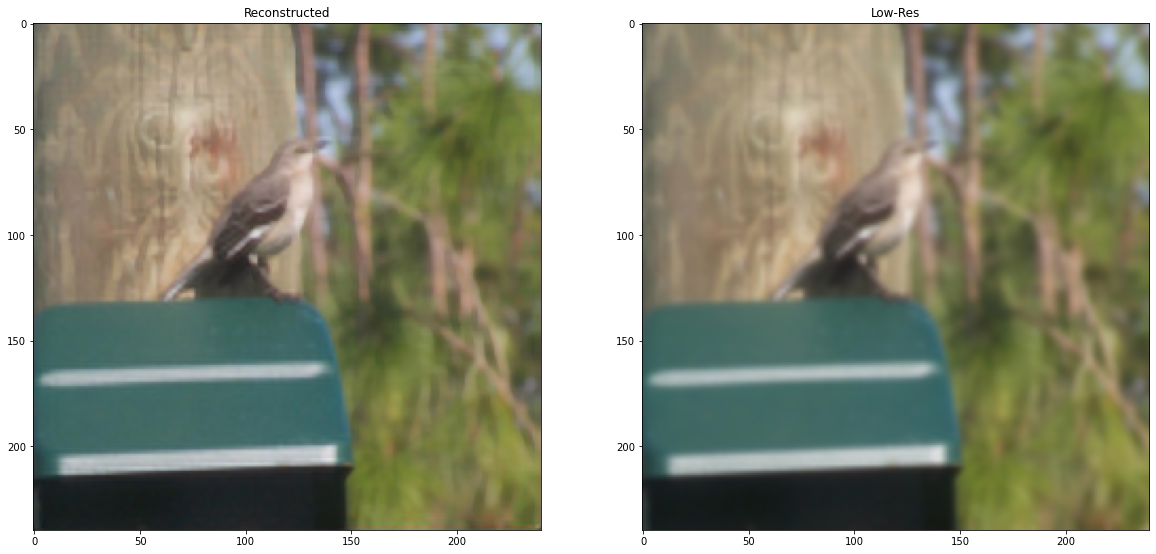

In [26]:
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(image)
axarr[1].imshow(inputs.cpu().permute(1, 2, 0))
axarr[0].set_title("Reconstructed")
axarr[1].set_title("Low-Res")

In [19]:
# image == i[1][0].permute(1, 2, 0)
print('reconstructed', PSNR(image, i[0][0].permute(1, 2, 0)).cpu().detach().numpy())
print('low resolution', PSNR(i[1][0].permute(1, 2, 0), i[0][0].permute(1, 2, 0)).cpu().detach().numpy())

reconstructed 83.81806
low resolution 82.606895
